---
output-file: individual.html
title: DHPCTIndividual
DHPCTIndividual: Deep Hierarchical Perceptual Control Theory Individual
---


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#| default_exp individual


In [3]:
#|export
import gymnasium as gym
import tensorflow as tf
import numpy as np
import json


In [ ]:
#|export
import tensorflow as tf
import numpy as np
import json

class DHPCTIndividual:
    """
    Represents an individual with a hierarchical PCT control system and an environment.
    """
    def __init__(self, env_name, env_props=None, levels=None, activation_funcs=None, weight_types=None):
        self.env_name = env_name
        self.env_props = env_props or {}
        self.levels = levels or []
        self.activation_funcs = activation_funcs or {}
        self.weight_types = weight_types or {}
        self.env = None
        self.model = None
        self.weights = {}

    @classmethod
    def from_config(cls, config_dict):
        env_cfg = config_dict.get('env', {})
        hier_cfg = config_dict.get('hierarchy', {})
        weights = config_dict.get('weights', {})
        obj = cls(
            env_name=env_cfg.get('env_name'),
            env_props=env_cfg.get('properties'),
            levels=hier_cfg.get('levels'),
            activation_funcs=hier_cfg.get('activation_funcs'),
            weight_types=hier_cfg.get('weight_types'),
        )
        obj.weights = weights
        return obj

    def compile(self):
        """
        Build the environment and Keras model according to the DPCT hierarchical PCT specification.
        """
        if not self.levels or not isinstance(self.levels, list) or not all(isinstance(l, int) and l > 0 for l in self.levels):
            raise ValueError("'levels' must be a non-empty list of positive integers. Got: {}".format(self.levels))
        self.env = gym.make(self.env_name, **self.env_props) if self.env_props else gym.make(self.env_name)
        # Observation and action space sizes
        space = self.env.observation_space
        shape = getattr(space, 'shape', None)
        if shape is not None and len(shape) > 0:
            obs_space = shape[0]
        elif isinstance(space, gym.spaces.Discrete):
            obs_space = 1
        else:
            raise ValueError("Unsupported observation space type")
        action_space = self.env.action_space
        act_shape = getattr(action_space, 'shape', None)
        if act_shape is not None and len(act_shape) > 0:
            act_space = act_shape[0]
        elif isinstance(action_space, gym.spaces.Discrete):
            act_space = action_space.n
        else:
            act_space = 1
        obs_input = tf.keras.Input(shape=(obs_space,), name='observation')
        ref_input = tf.keras.Input(shape=(self.levels[-1],), name='reference') if self.levels else tf.keras.Input(shape=(1,), name='reference')
        perceptions = []
        references = []
        comparators = []
        outputs = []
        x = tf.keras.layers.Dense(self.levels[0], use_bias=False, activation=None, name='level0_perception')(obs_input)
        perceptions.append(x)
        ref0 = tf.keras.layers.Lambda(lambda t: tf.zeros_like(t), name='level0_reference')(x)
        references.append(ref0)
        comp0 = tf.keras.layers.Subtract(name='level0_comparator')([ref0, x])
        comparators.append(comp0)
        out0_weights = tf.keras.layers.Dense(self.levels[0], use_bias=False, activation=None, name='level0_output_weights')(comp0)
        out0 = tf.keras.layers.Multiply(name='level0_output')([comp0, out0_weights])
        outputs.append(out0)
        for i in range(1, len(self.levels)):
            p = tf.keras.layers.Dense(self.levels[i], use_bias=False, activation=None, name=f'level{i}_perception')(perceptions[i-1])
            perceptions.append(p)
            if i == len(self.levels)-1:
                ref = tf.keras.layers.Lambda(lambda inputs: inputs[0] - tf.zeros_like(inputs[1]), name=f'level{i}_reference')([ref_input, p])
            else:
                ref = tf.keras.layers.Dense(self.levels[i], use_bias=False, activation=None, name=f'level{i}_reference')(outputs[i-1])
            references.append(ref)
            comp = tf.keras.layers.Subtract(name=f'level{i}_comparator')([ref, p]) # type: ignore
            comparators.append(comp)
            out_weights = tf.keras.layers.Dense(self.levels[i], use_bias=False, activation=None, name=f'level{i}_output_weights')(comp)
            out = tf.keras.layers.Multiply(name=f'level{i}_output')([comp, out_weights])
            outputs.append(out)
        actions = tf.keras.layers.Dense(act_space, activation='linear', name='actions')(outputs[0])
        model_outputs = [actions] + comparators
        self.model = tf.keras.Model(inputs=[obs_input, ref_input], outputs=model_outputs)

    def config(self):
        return {
            'env': {
                'env_name': self.env_name,
                'properties': self.env_props
            },
            'hierarchy': {
                'levels': self.levels,
                'activation_funcs': self.activation_funcs,
                'weight_types': self.weight_types
            },
            'weights': self.weights
        }

    def save_config(self, filepath):
        try:
            with open(filepath, 'w') as f:
                json.dump(self.config(), f, indent=2)
            return True
        except Exception:
            return False

    def run(self, steps, train=False, early_termination=False):
        """
        Run the individual in its environment
        Parameters:
        - steps: Number of timesteps to run
        - train: Whether to enable online learning during execution
        - early_termination: Whether to terminate early based on environment signals
        """
        if not self.levels or len(self.levels) == 0:
            raise ValueError("Hierarchy levels are not defined. Please provide a non-empty levels list.")
        if self.env is None or self.model is None:
            self.compile()
        if self.env is None:
            raise RuntimeError("Environment is not initialized. Call compile() first.")
        if self.model is None:
            raise RuntimeError("Model is not initialized. There was an error during compile().")
        obs = self.env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        total_reward = 0
        for _ in range(steps):
            obs_input = np.expand_dims(obs, axis=0)
            ref_input = np.zeros((1, self.levels[-1])) if self.levels else np.zeros((1, 1))
            model_outputs = self.model([obs_input, ref_input])
            actions = model_outputs[0].numpy().squeeze()
            if hasattr(self.env.action_space, 'n'):
                action = int(np.argmax(actions))
            else:
                action = actions
            step_result = self.env.step(action)
            if len(step_result) == 5:
                obs, reward, terminated, truncated, _ = step_result
            else:
                obs, reward, done, _ = step_result
                terminated = done
                truncated = False
            total_reward += reward
            if early_termination and (terminated or truncated):
                break

        self.env.close()
        return total_reward

    def mate(self, other):
        """
        Create two new individuals by crossing this one with another.
        Structure is crossed over (one-point crossover), weights are blended.
        Returns:
            tuple: (child1, child2) as new DHPCTIndividual instances
        """
        import copy
        import random
        # Crossover for levels (structure): one-point crossover
        if not self.levels or not other.levels or len(self.levels) != len(other.levels):
            # fallback: just copy
            return copy.deepcopy(self), copy.deepcopy(other)
        point = random.randint(1, len(self.levels)-1)
        child1_levels = self.levels[:point] + other.levels[point:]
        child2_levels = other.levels[:point] + self.levels[point:]
        # Crossover for activation_funcs and weight_types (shallow merge)
        child1_af = {**self.activation_funcs, **{k: other.activation_funcs.get(k, v) for k, v in self.activation_funcs.items()}}
        child2_af = {**other.activation_funcs, **{k: self.activation_funcs.get(k, v) for k, v in other.activation_funcs.items()}}
        child1_wt = {**self.weight_types, **{k: other.weight_types.get(k, v) for k, v in self.weight_types.items()}}
        child2_wt = {**other.weight_types, **{k: self.weight_types.get(k, v) for k, v in other.weight_types.items()}}
        # Blend weights if present (simple average for matching keys)
        def blend_weights(w1, w2):
            if not w1 or not w2:
                return w1 or w2 or {}
            blended = {}
            for k in set(w1.keys()).union(w2.keys()):
                v1 = w1.get(k)
                v2 = w2.get(k)
                if isinstance(v1, (int, float)) and isinstance(v2, (int, float)):
                    blended[k] = (v1 + v2) / 2
                elif isinstance(v1, dict) and isinstance(v2, dict):
                    blended[k] = blend_weights(v1, v2)
                else:
                    blended[k] = v1 if v1 is not None else v2
            return blended
        child1_weights = blend_weights(self.weights, other.weights)
        child2_weights = blend_weights(other.weights, self.weights)
        # Create children
        child1 = DHPCTIndividual(
            env_name=self.env_name,
            env_props=copy.deepcopy(self.env_props),
            levels=child1_levels,
            activation_funcs=child1_af,
            weight_types=child1_wt
        )
        child2 = DHPCTIndividual(
            env_name=other.env_name,
            env_props=copy.deepcopy(other.env_props),
            levels=child2_levels,
            activation_funcs=child2_af,
            weight_types=child2_wt
        )
        child1.weights = child1_weights
        child2.weights = child2_weights
        return child1, child2

    def mutate(self, struct_prob=0.1, weight_prob=0.1):
        # Placeholder: no-op
        pass

    def evaluate(self, nevals=1):
        # Placeholder: average reward over nevals runs
        scores = [self.run(steps=200) for _ in range(nevals)]
        return np.mean(scores)


In [5]:
# Basic test: instantiate, compile, and run DHPCTIndividual
ind = DHPCTIndividual(env_name='CartPole-v1', levels=[2, 2], activation_funcs={0: 'relu', 1: 'tanh'})
ind.compile()
print('Config:', ind.config())



Config: {'env': {'env_name': 'CartPole-v1', 'properties': {}}, 'hierarchy': {'levels': [2, 2], 'activation_funcs': {0: 'relu', 1: 'tanh'}, 'weight_types': {}}, 'weights': {}}


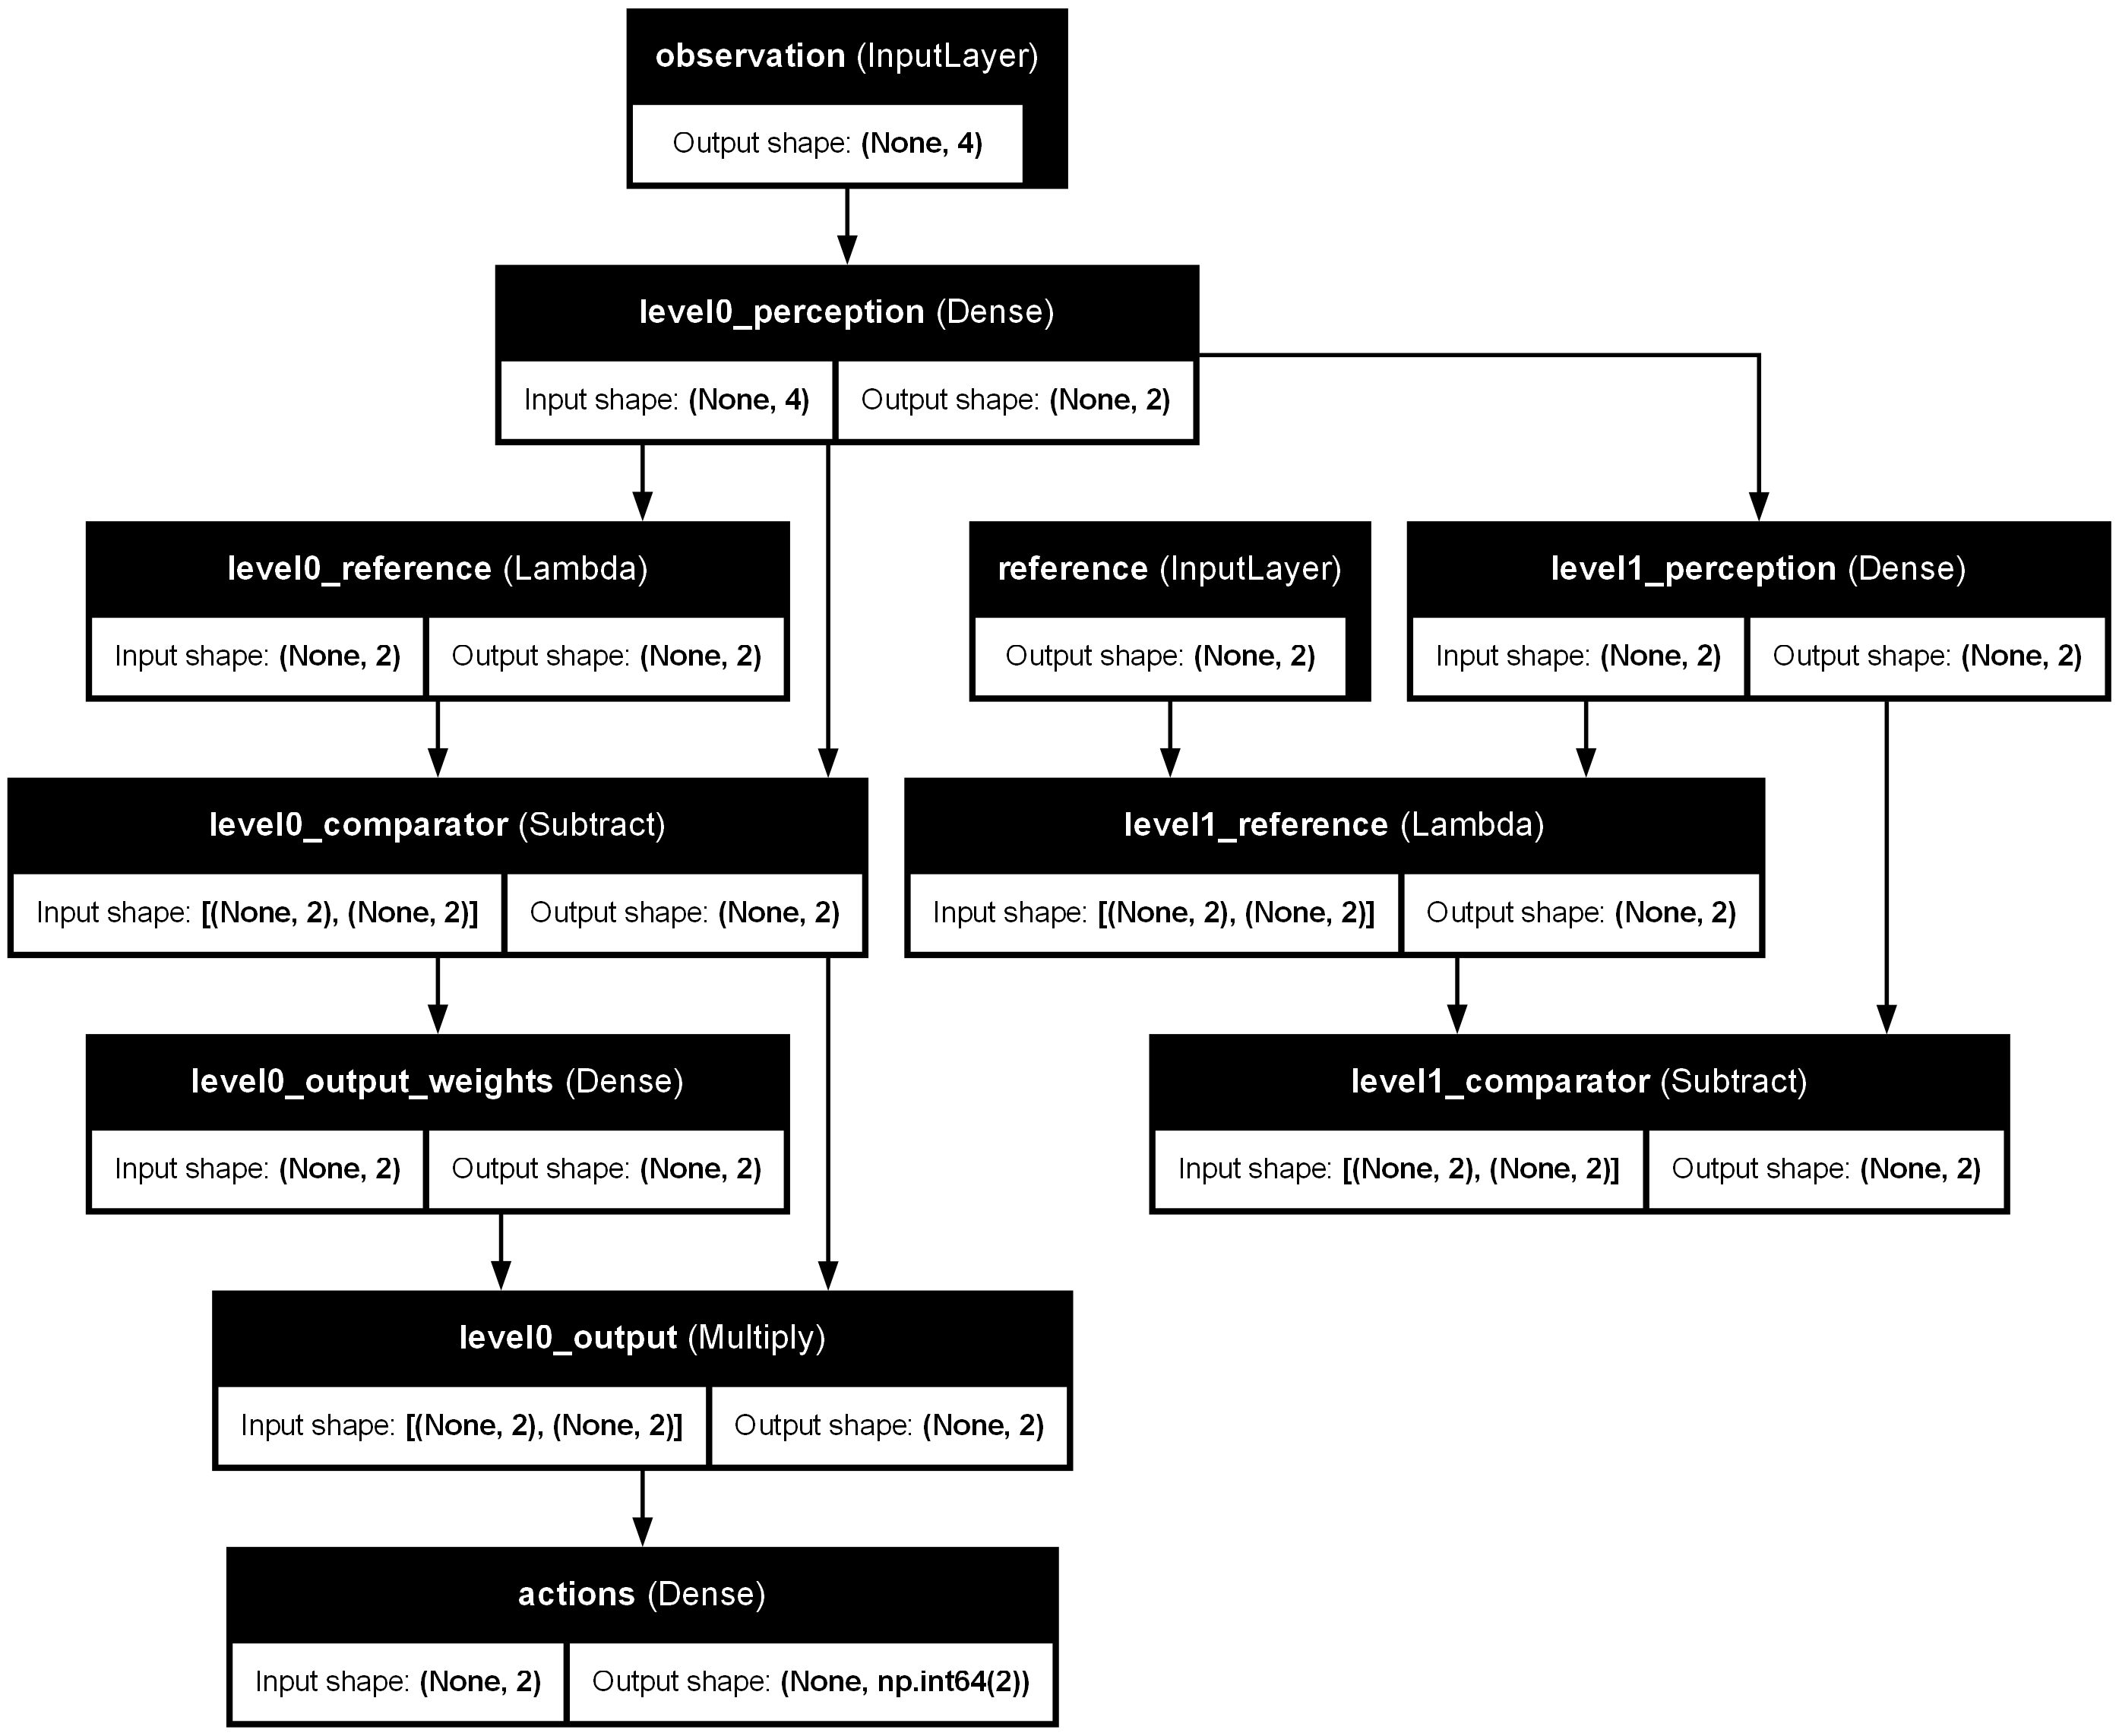

In [6]:
tf.keras.utils.plot_model(ind.model, show_shapes=True, show_layer_names=True)

In [7]:
result = ind.run(steps=10)
print('Total reward for 10 steps:', result)

Total reward for 10 steps: 10.0


In [8]:
#| hide
import nbdev; nbdev.nbdev_export()